# 循环神经网络的简洁实现


虽然 `sec_rnn_scratch`
对了解循环神经网络的实现方式具有指导意义，但并不方便。
本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。
我们仍然从读取时光机器数据集开始。


In [2]:
import torch
import os
from torch import nn
from torch.nn import functional as F
# from d2l import torch as d2l

import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l

# 数据加载
from d2lzh_pytorch.nlp.load_data.load_time_machine import load_data_time_machine

# 模型加载
from d2lzh_pytorch.nlp.model.RNN_model import RNNModel

# 训练加载, 预测加载
from d2lzh_pytorch.nlp.train.train_ch8 import train_ch8, predict_ch8

## 加载训练数据和词元

In [4]:
batch_size = 32
num_steps = 35

# BASE: /mnt/g1t/ai_data/Datasets_on_HHD/NLP/text_data
BASE_PATH = "/mnt/g1t/ai_data/Datasets_on_HHD/NLP/text_data"

# 加载
txtPath = os.path.join(BASE_PATH, "贾平凹-山本.txt")
stopwords_file = os.path.join(BASE_PATH, "stopwords.txt")

# 返回封装的数据
train_iter, vocab = load_data_time_machine(batch_size, num_steps, txtPath, stopwords_file)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.236 seconds.
Prefix dict has been built successfully.


load vocabulary success. len(vocab): 3577


## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。
事实上，我们还没有讨论多层循环神经网络的意义（这将在 `sec_deep_rnn`中介绍）。
现在仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。


## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [5]:
device = d2l.try_gpu()


num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)


net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

In [7]:
from torchsummary import summary

summary(net)


Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               981,760
├─Linear: 1-2                            919,289
Total params: 1,901,049
Trainable params: 1,901,049
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               981,760
├─Linear: 1-2                            919,289
Total params: 1,901,049
Trainable params: 1,901,049
Non-trainable params: 0

In [6]:
net

RNNModel(
  (rnn): RNN(3577, 256)
  (linear): Linear(in_features=256, out_features=3577, bias=True)
)

In [4]:

# 这里是简单预测, 发现效果差
d2l.predict_ch8('山本', 
                10, net, vocab, 
                device)

'山本陋景珊垒刺缓刺s陆你'

很明显，这种模型根本不能输出好的结果。
接下来，我们使用 :numref:`sec_rnn_scratch`中
定义的超参数调用`train_ch8`，并且[**使用高级API训练模型**]。


困惑度 189.3, 483070.6 词元/秒 cuda:0
time<unk>tra<unk>eller一块一口一口一块一块一口一口一块一块一口一块一块一块一块一块一块一块一块一块一块一块一块一块一块一块
tra<unk>eller里一家一口一下一块一块一口一块一块一块一块一块一块一块一块一块一块一块一块一块一块一块一块一块一块一


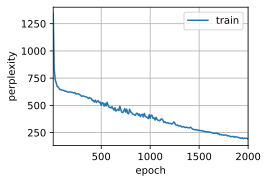

In [5]:
num_epochs = 2000
lr = 0.1


# 开始训练
train_ch8(net, train_iter, 
          vocab, lr, 
          num_epochs, 
          device
         )

In [9]:

# 预测
predict_ch8('保安队', 20, 
            net, vocab, device
           )


'保安队一口一口一块一块一口一块一块一块一块一块'

In [ ]:
# 保存模型
net = net.to("cpu")

import datetime
str_time = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
torch.save(net, 'concise_RNN_%s.pt' % str_time)  # 全保存 39M
print("训练完毕, 模型已保存至当前路径")

In [ ]:
# 加载模型
net = RNNModel(rnn_layer, vocab_size=len(vocab))

net = torch.load("concise_RNN_2023-06-28_12-55-17.pt")

In [12]:
net

RNNModel(
  (rnn): RNN(3577, 256)
  (linear): Linear(in_features=256, out_features=3577, bias=True)
)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，
该模型在较短的时间内达到了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们还需要计算整个模型的输出层。
* 相比从零开始实现的循环神经网络，使用高级API实现可以加速训练。


In [11]:
# 使用保存的模型 预测
# net = net.to(device)


# 预测
predict_ch8('保安队说', 40, 
            net, vocab, device
            )

'保安队说天个一个一子里子里说天子里一块一口一口一块一块一口一口一块一块一口一口一块一块一'